In [1]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt

/opt/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA ANALYSIS

In [2]:
df = pd.read_csv('dataset/mock_kaggle.csv', parse_dates=['data'])
print(df.shape)

df['id'] = 1
df.rename(columns={'data': 'timestamp'}, inplace=True)
df.tail()

(937, 4)


,timestamp,venda,estoque,preco,id
932,2016-07-27,98,3179,2.39,1
933,2016-07-28,108,3071,2.39,1
934,2016-07-29,128,4095,2.39,1
935,2016-07-30,270,3825,2.39,1
936,2016-07-31,183,3642,2.39,1


In [3]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df[:900],
    id_column="id",
    timestamp_column="timestamp"
)

predictor = TimeSeriesPredictor(
    prediction_length=37,
    target="venda",
    eval_metric="RMSE",
    freq="D",
    known_covariates_names=["estoque", "preco"],
    path='model'
)

## TRAIN MODEL

In [4]:
# predictor.fit(
#     train_data,
#     presets="best_quality",
#     time_limit=900,
#     num_val_windows=5,
# )
# predictor.delete_models(models_to_keep='best', dry_run=False)

## LOAD MODEL

In [5]:
model = predictor.load('model')

Loading predictor from path model


## INFER DATA

In [6]:
covariates = TimeSeriesDataFrame.from_data_frame(
    df[['id', 'timestamp', 'estoque', 'preco']], 
    timestamp_column="timestamp", 
    id_column="id"
)

forecast = model.predict(train_data, known_covariates=covariates)
forecast.head()

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
1       2016-06-25  208.126900  127.569456  169.851826  186.568106   
        2016-06-26  179.535002   98.677234  136.981695  159.545339   
        2016-06-27  104.041256   27.866424   60.745681   77.883215   
        2016-06-28   83.787902    5.106155   37.487800   54.625627   
        2016-06-29   89.201375    0.586413   38.853607   58.705617   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
1       2016-06-25  202.428046  210.164628  236.085264  244.994495   
        2016-06-26  167.841133  178.757069  207.159268  222.498866   
        2016-06-27   92.608738  104.686380  127.697320  134.014720   
        2016-06-28   68.246646   83.156922  107.994762  115.315271   
        2016-06-29   72.502447   89.539065  116.383405  126.447652   

                           0.8         0.9  
item_id timestamp                           
1       2016-06-25  266.341439  313.412168  
        2016-06-26  236.586668  284.322095  
        2016-06-27  147.759429  180.893786  
        2016-06-28  130.969416  169.573995  
        2016-06-29  143.224999  190.989923

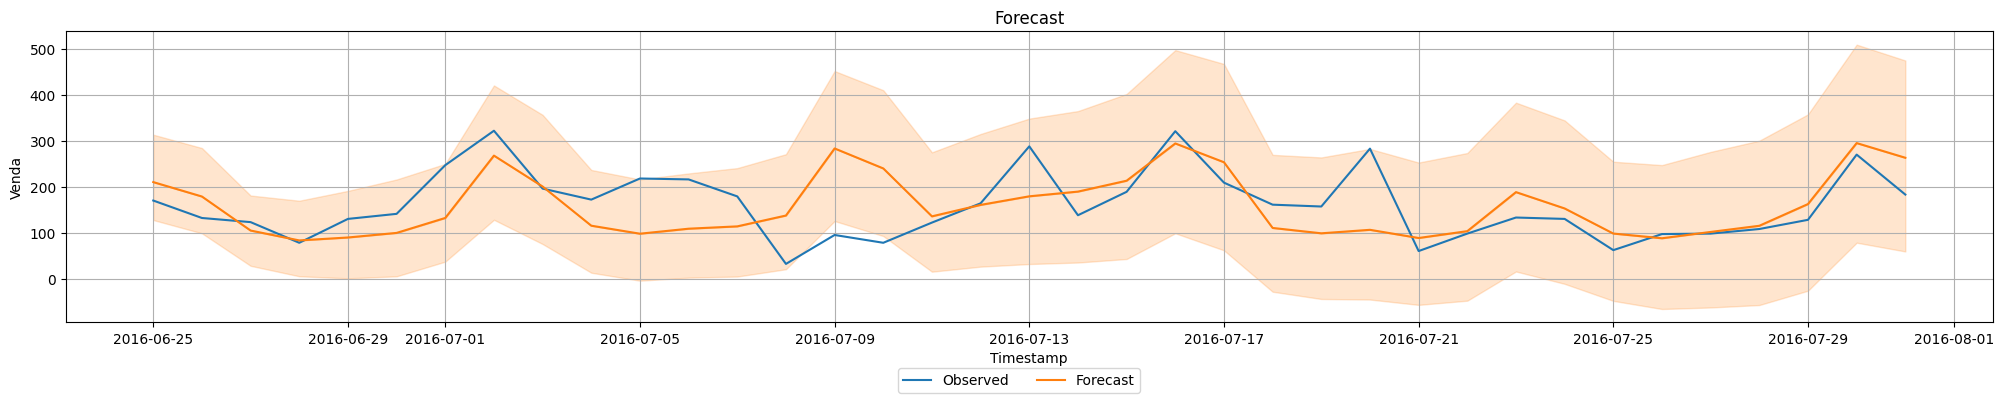

In [13]:
test_data = TimeSeriesDataFrame.from_data_frame(
    df[900:],
    id_column="id",
    timestamp_column="timestamp"
)

model.plot(test_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)
plt.title('Previsão de 37 dias de vendas')
plt.xlabel('Timestamp')
plt.ylabel('Venda')
plt.show()

In [10]:
model.evaluate(train_data)

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'RMSE': -116.12843310336113}